In [78]:
import numpy as np
import pandas as pd
import scipy as sp
import plotly.express as px
import networkx as nx
import degroot as dg
from tqdm import tqdm
import plotly.graph_objects as go
from joblib import Parallel, delayed

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# Parameters
dims = 8
watts_strogatz_p = 0.3
init_belief = np.random.uniform(0, 1, size=dims)
niter_degroot = 2

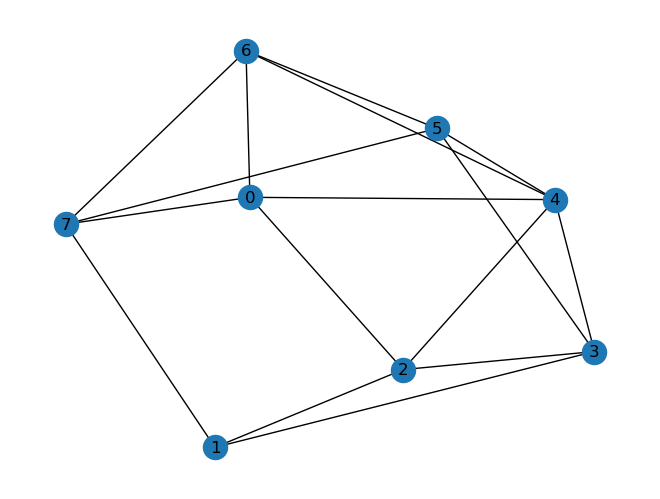

In [81]:
n = nx.connected_watts_strogatz_graph(n=dims, k=4, p=0.3)
nx.draw(n, with_labels=True)
m_base = nx.adjacency_matrix(n).todense()

In [83]:
rewiring_sample = dg.get_rewiring_sample(m_base, n_rewiring_attempts=1000)
len(rewiring_sample)

1000

In [49]:
correct_belief = 0.9

In [50]:
dg.degroot_err(m_base, init_belief, correct_belief, niter_degroot)

(0.4608731220788567,
 array([0.50589352, 0.4196593 , 0.45500174, 0.38712612, 0.36977835,
        0.46854892, 0.53417985, 0.37282722]))

In [51]:
peaks = dg.find_local_peaks(sample=rewiring_sample, initial_belief=init_belief, correct_belief=correct_belief, niter_degroot=niter_degroot, vision=2)

100%|██████████| 100/100 [00:09<00:00, 10.81it/s]


In [64]:
df = dg.extract_local_peak_stats(peaks)
df

,peak_label,error,estimate,count
0,0,0.303987,0.596013,2
1,1,0.292830,0.607170,71
2,2,0.293404,0.606596,9
3,3,0.292830,0.607170,18


In [65]:
unique_peaks = np.unique([p['m'].flatten() for p in peaks], axis=0)
unique_peaks = [p.reshape(m_base.shape) for p in unique_peaks]
m0 = unique_peaks[0]
m1 = unique_peaks[1]
err0, b0 = dg.degroot_err(m0, init_belief, correct_belief, niter_degroot)
err1, b1 = dg.degroot_err(m1, init_belief, correct_belief, niter_degroot)
err0, err1

(0.3039869919992575, 0.29282958708636797)

In [77]:
nbrs0 = dg._get_neighbors_within_distance_k(m0, 3)
len(nbrs0)

106015

In [76]:
nbr_err = []
for nbr in nbrs0:
    err_nbr, belief_nbr = dg.degroot_err(nbr, init_belief, correct_belief, niter_degroot)
    if err_nbr < err0:
        print('Found a better neighbor')
        err = err_nbr
        beliefs = belief_nbr

    nbr_err.append(err_nbr)

In [193]:
hist, bins = np.histogram(nbr_err, bins=20)
px.bar(x=bins[:-1], y=hist)